In [11]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

## Scrapping available products
### Initialization

In [21]:
driver = webdriver.Chrome()
driver2 = webdriver.Chrome()

In [16]:
href_set = set()
page_no = 0
count_per_page = 20

### Get a list of products

In [17]:
total_count = count_per_page * 3
while page_no * count_per_page < total_count :
    expected_count = min(count_per_page, total_count - page_no * count_per_page) #last page might consist less products
    page_no += 1
    
    link = f"https://www.euro.com.pl/telewizory-led-lcd-plazmowe,przekatna-ekranu-relacje!od-50-do-59-cali,od2000do3500,strona-{page_no}.bhtml"
#     link = f"https://www.euro.com.pl/laptopy-i-netbooki,strona-{page_no}.bhtml"
    driver.get(link)
#     WebDriverWait(driver, 20).until( 
#         lambda d: len(driver.find_elements(by=By.CLASS_NAME, value='box-medium__link'))>= expected_count )
    time.sleep (10)
    print(f"Loading {page_no} page.")
    
    if page_no == 1:
        items_count = driver.find_elements(by=By.CLASS_NAME, value='body-2-b')[-1]
        total_count = int(items_count.text.split(" ")[-1])
        print(f"Total products count is {total_count}.")
        
    elements_by_class = driver.find_elements(by=By.CLASS_NAME, value='product-medium-box-intro__link')
    for index, element in enumerate(elements_by_class):
        value_info = element.get_attribute("href")
        href_set.add(value_info)
        print(f"{len(href_set)}) Link: {value_info}")   

Loading 1 page.
Total products count is 53.
1) Link: https://www.euro.com.pl/telewizory-led-lcd-plazmowe/lg-telewizor-55qned823re-lg-qned-100hz.bhtml
2) Link: https://www.euro.com.pl/telewizory-led-lcd-plazmowe/lg-55nano763qa-tv-qned-uhd-4k.bhtml
3) Link: https://www.euro.com.pl/telewizory-led-lcd-plazmowe/samsung-telewizor-qe55q80catxxh.bhtml
4) Link: https://www.euro.com.pl/telewizory-led-lcd-plazmowe/tcl-telewizor-55qled870.bhtml
5) Link: https://www.euro.com.pl/telewizory-led-lcd-plazmowe/samsung-telewizor-qe55q67cauxxh.bhtml
6) Link: https://www.euro.com.pl/telewizory-led-lcd-plazmowe/samsung-telewizor-qe50q67cauxxh.bhtml
7) Link: https://www.euro.com.pl/telewizory-led-lcd-plazmowe/lg-50nano763qa-tv-nanocell-uhd-4k.bhtml
8) Link: https://www.euro.com.pl/telewizory-led-lcd-plazmowe/sharp-telewizor-55fq8.bhtml
9) Link: https://www.euro.com.pl/telewizory-led-lcd-plazmowe/samsung-telewizor-ue55du8002kxxh.bhtml
10) Link: https://www.euro.com.pl/telewizory-led-lcd-plazmowe/lg-telewizor-

### Saving / loading scraped data for future use

In [18]:
# saving data
# with open('datasets/href_euro_tv_set.txt', 'w') as file:
with open('datasets/href_euro_set.txt', 'w') as file:
    for item in href_set:
        file.write(item + '\n')

In [ ]:
# loading data
href_set = set()
with open('datasets/href_euro_set.txt', 'r') as file:
    for line in file:
        href_set.add(line.strip())

In [15]:
len(href_set)

0

## Scrapping particular products information

In [19]:
#DataFrame init
df = pd.DataFrame(columns=['Nazwa','Cena','Link'])

### Scrapping data from listed links

In [24]:
def scrap_data_from_driver(driver, link):
    record = {}

    #wait till the relevant button is working and click it to extend table
    
    WebDriverWait(driver, 10).until(  
        lambda d: driver.find_element(by=By.XPATH, value='//*[@id="technical-details"]/ems-euro-mobile-product-card-technical-attributes/div/div/ems-collapse-button/button').is_displayed())

    driver.find_element(by=By.XPATH, value='//*[@id="technical-details"]/ems-euro-mobile-product-card-technical-attributes/div/div/ems-collapse-button/button').click()

    #get name and price of product and assign to dict
    name = driver.find_element(by=By.CLASS_NAME, value='product-intro__title-text').text
    price = driver.find_elements(by=By.CLASS_NAME, value='price-template__large--total')

    print(f'{len(df)+1}) Loading page of "{name[:30]}"...')

    record = {}
    record['Nazwa'] = name
    if len(price)!= 0:
        record['Cena'] = int(price[0].text.replace(" ",""))
    record['Link'] = link

    # retrieve other data of product
    attribute_values = driver.find_elements(by=By.CLASS_NAME, value='technical-attributes__attribute-value')
    attribute_names  = driver.find_elements(by=By.CLASS_NAME, value='technical-attributes__attribute-name')
    assert len(attribute_names) == len(attribute_values)

    for element in zip(attribute_names, attribute_values):
        name = element[0].text.replace(":","") #remove unnecessary punctuation
        record[name] =element[1].text
    
    return record

In [25]:
links = list(href_set)
iterator = iter(links)
for link, link2 in zip(iterator, iterator):
    
    if len(df[df['Link'] == link]) == 0 : #if product was already read skip reload
        driver.get(link)
    if len(df[df['Link'] == link2]) == 0 : #if product was already read skip reload
        driver2.get(link2)
        
        
    if len(df[df['Link'] == link]) > 0 : #if product was already read skip reload
        print(f'"{df[df["Link"] == link]["Nazwa"].iloc[0][:30]}..." was skipped')
    else:
        record = scrap_data_from_driver(driver, link)
        data_row = pd.DataFrame.from_records(data=[record])
        df = pd.concat([df, data_row]) # DF during concatenation can extend by columns, that were not met before
        
        
    if len(df[df['Link'] == link2]) > 0 : #if product was already read skip reload
        print(f'"{df[df["Link"] == link2]["Nazwa"].iloc[0][:30]}..." was skipped')
    else:
        record = scrap_data_from_driver(driver2, link2)
        data_row = pd.DataFrame.from_records(data=[record])
        df = pd.concat([df, data_row])
    
df.reset_index(inplace= True)

1) Loading page of "Telewizor Philips 55PUS8057/12"...
2) Loading page of "Telewizor Sharp 55GP6760E 55" "...
3) Loading page of "Telewizor Sony KD-50X73K 50" L"...
4) Loading page of "Telewizor Philips The One 55PU"...
5) Loading page of "Telewizor Samsung UE55DU7192U "...
6) Loading page of "Telewizor Philips 50PUS8057/12"...
7) Loading page of "Telewizor Toshiba 55UA3E63DG 5"...
8) Loading page of "Telewizor Philips 50PUS8319/12"...
9) Loading page of "Telewizor Philips The One 58PU"...
10) Loading page of "Telewizor Samsung The Frame QE"...
11) Loading page of "Telewizor Philips The One 50PU"...
12) Loading page of "Telewizor LG 55QNED823RE 55" L"...
13) Loading page of "Telewizor Samsung The Frame QE"...
14) Loading page of "Telewizor Samsung UE55CU8002K "...
15) Loading page of "Telewizor Sony KD-55X81K 55" L"...
16) Loading page of "Telewizor Toshiba 55QV2463DG 5"...
17) Loading page of "Telewizor TCL 55C655 Pro 55" Q"...
18) Loading page of "Telewizor Panasonic TX-55MX600"...
1

### Saving / loading scraped data for future use

In [26]:
#saving data to file
# df.to_parquet(path='datasets/euro_product_full_tv_data.gzip',
df.to_parquet(path='datasets/euro_product_full_data.gzip',
              compression='gzip')

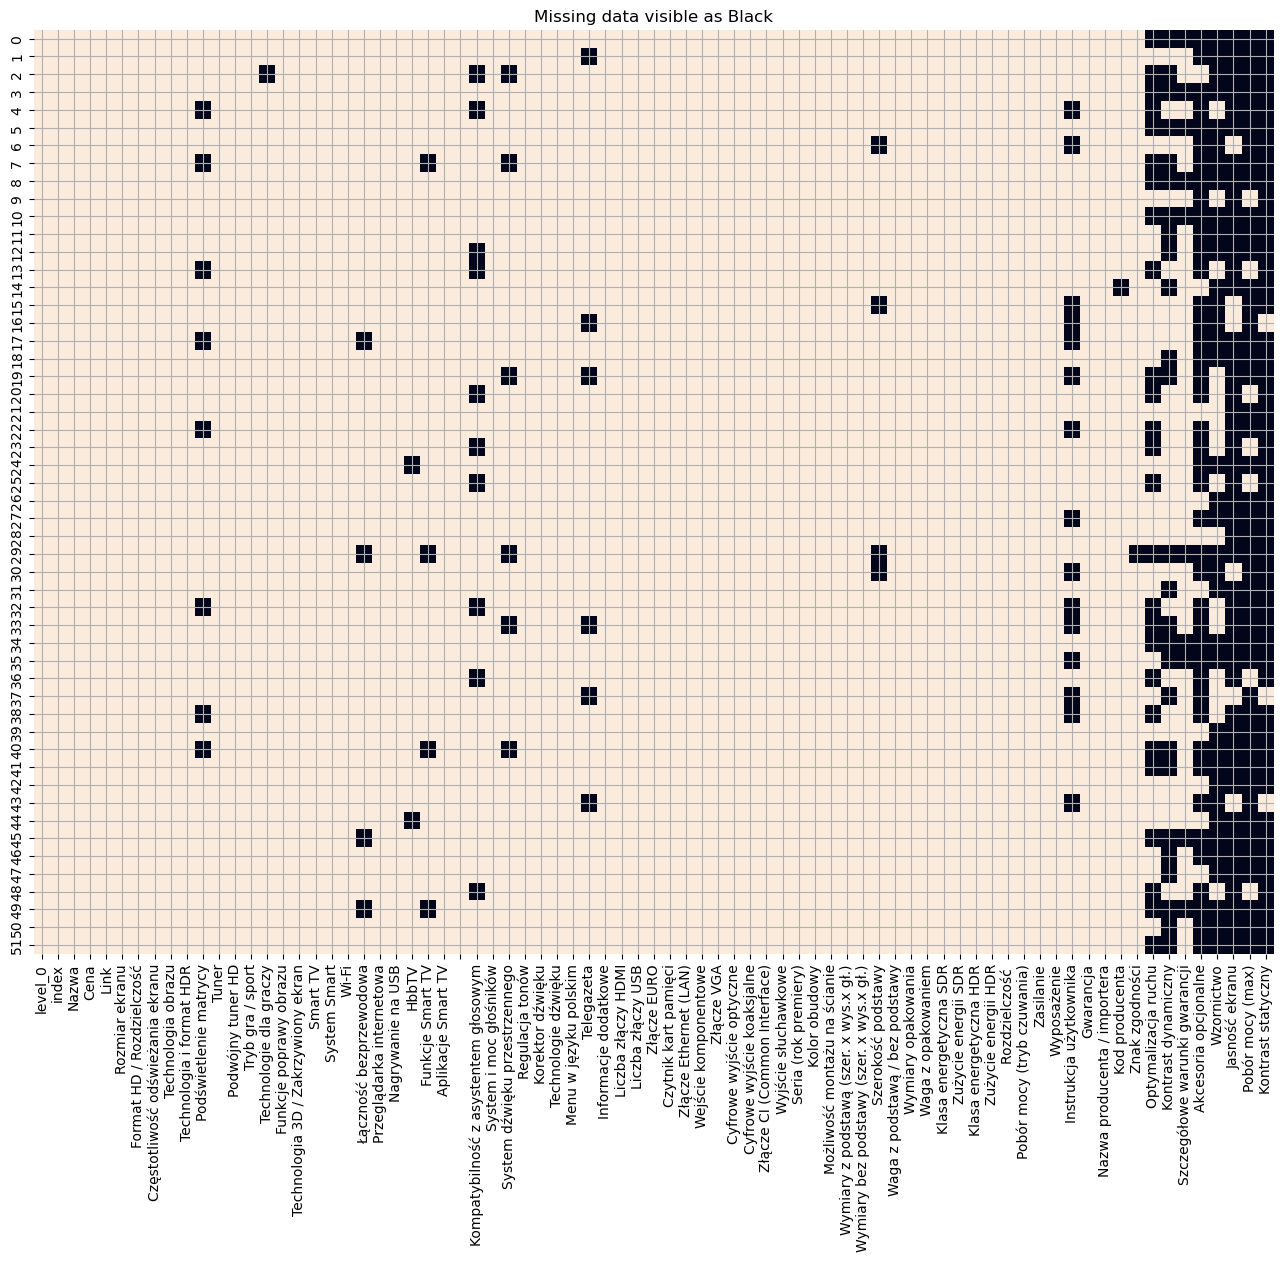

In [28]:
plt.figure(figsize=(16,12))
sns.heatmap(df.reset_index().notna(), cbar=False)
plt.grid()
plt.title("Missing data visible as Black")
plt.show()

In [29]:
df.head()

,index,Nazwa,Cena,Link,Rozmiar ekranu,Format HD / Rozdzielczość,Częstotliwość odświeżania ekranu,Technologia obrazu,Technologia i format HDR,Podświetlenie matrycy,...,Kod producenta,Znak zgodności,Optymalizacja ruchu,Kontrast dynamiczny,Szczegółowe warunki gwarancji,Akcesoria opcjonalne,Wzornictwo,Jasność ekranu,Pobór mocy (max),Kontrast statyczny
0,0,"Telewizor Philips 55PUS8057/12 55"" LED 4K Andr...",2490,https://www.euro.com.pl/telewizory-led-lcd-pla...,"55 "" / 139 cm",4K UHD / 3840 x 2160,50 Hz / 60 Hz,LED,"tak / Dolby Vision, HDR10, HDR10+, HLG (Hybrid...",Direct LED,...,55PUS8057/12,DIGITALEUROPE Ultra HD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,"Telewizor Sharp 55GP6760E 55"" QLED 4K GoogleTV...",2199,https://www.euro.com.pl/telewizory-led-lcd-pla...,"55 "" / 139 cm",4K UHD / 3840 x 2160,50 Hz / 60 Hz,"QLED, LED","tak / Dolby Vision, HDR10, HLG (Hybrid Log-Gamma)",Direct LED,...,55GP6760E,DIGITALEUROPE Ultra HD,Active Motion 1000,1000000 :1,Pobierz,NaN,NaN,NaN,NaN,NaN
2,0,"Telewizor Sony KD-50X73K 50"" LED 4K Android TV...",2190,https://www.euro.com.pl/telewizory-led-lcd-pla...,"50 "" / 126 cm",4K UHD / 3840 x 2160,50 Hz / 60 Hz,LED,"tak / HDR10, HLG (Hybrid Log-Gamma)",Direct LED,...,KD50X73KPAEP,DIGITALEUROPE Ultra HD,NaN,NaN,Pobierz,"uchwyt ścienny SU-WL450, moduł kamery CMU-BC1",NaN,NaN,NaN,NaN
3,0,"Telewizor Philips The One 55PUS8807/12 55"" LED...",2990,https://www.euro.com.pl/telewizory-led-lcd-pla...,"55 "" / 139 cm",4K UHD / 3840 x 2160,100 Hz / 120 Hz,LED,"tak / Dolby Vision, HDR10, HDR10+, HLG (Hybrid...",Direct LED,...,55PUS8807/12,DIGITALEUROPE Ultra HD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,"Telewizor Samsung UE55DU7192U 55"" LED 4K Tizen...",2499,https://www.euro.com.pl/telewizory-led-lcd-pla...,"55 "" / 139 cm",4K UHD / 3840 x 2160,50 Hz / 60 Hz,LED,"tak / HDR10+, HLG (Hybrid Log-Gamma)",NaN,...,UE55DU7192UXXH,DIGITALEUROPE Ultra HD,NaN,Mega,Pobierz,NaN,Slim Look,NaN,NaN,NaN
